In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
data_dir = '/content/drive/MyDrive/dataset/main'
batch_size = 32
img_height = 180
img_width = 180

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17676 files belonging to 7 classes.
Using 14141 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17676 files belonging to 7 classes.
Using 3535 files for validation.


In [5]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [6]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.026065798 0.78934014


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
num_classes = 7

In [9]:
RN50 = ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))
input = RN50.output
input = layers.GlobalAveragePooling2D()(input)
# input = layers.Dropout(0.2)
fpred = layers.Dense(num_classes, activation = 'softmax')(input)
model = tf.keras.models.Model(inputs = RN50.input, outputs = fpred)

94773248/94765736 [==============================] - 1s 0us/step


In [10]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [11]:
class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.965):
            print("\n 96% val_acc reached")
            self.model.stop_training = True

In [12]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  callbacks = [CustomCallbacks()]
)

Epoch 1/15
442/442 [==============================] - 8788s 20s/step - loss: 1.1549 - accuracy: 0.5893 - val_loss: 1.6092 - val_accuracy: 0.6158
Epoch 2/15
442/442 [==============================] - 109s 247ms/step - loss: 0.3413 - accuracy: 0.8848 - val_loss: 0.6878 - val_accuracy: 0.7884
Epoch 3/15
442/442 [==============================] - 109s 247ms/step - loss: 0.2174 - accuracy: 0.9248 - val_loss: 1.0621 - val_accuracy: 0.6557
Epoch 4/15
442/442 [==============================] - 109s 247ms/step - loss: 0.1408 - accuracy: 0.9507 - val_loss: 0.8915 - val_accuracy: 0.7092
Epoch 5/15
442/442 [==============================] - 110s 248ms/step - loss: 0.1191 - accuracy: 0.9585 - val_loss: 0.6725 - val_accuracy: 0.7825
Epoch 6/15
442/442 [==============================] - 110s 248ms/step - loss: 0.1017 - accuracy: 0.9640 - val_loss: 0.5067 - val_accuracy: 0.8328
Epoch 7/15
442/442 [==============================] - 110s 248ms/step - loss: 0.0732 - accuracy: 0.9750 - val_loss: 0.2125 - 

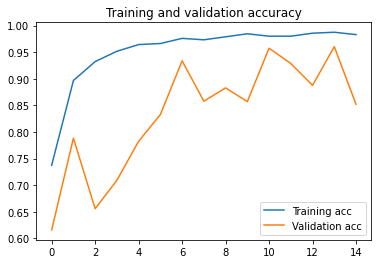

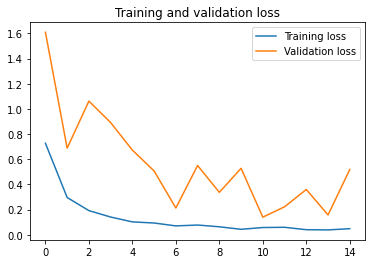

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.save("/content/drive/MyDrive/ResNet_Model1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ResNet_Model1/assets
